In [ ]:
import os
import time
import torch
import numpy as np
from torch.utils import data
from loader.real_data_loader import real_data_loader
from utils.data import *
from models.unet import Unet
from models.utils import *
from models.discriminator import Basic_D
from utils.train import *
from IPython.display import clear_output
from utils.loss import *
from models.dc_blocks import *
from models.unet_with_dc import *

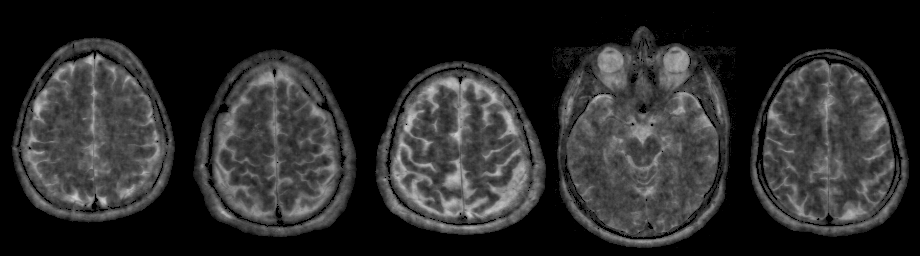

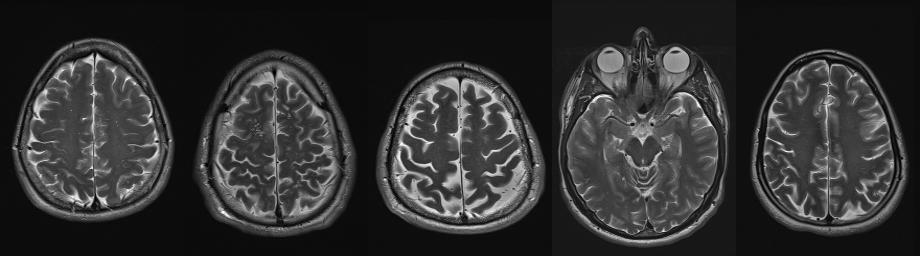

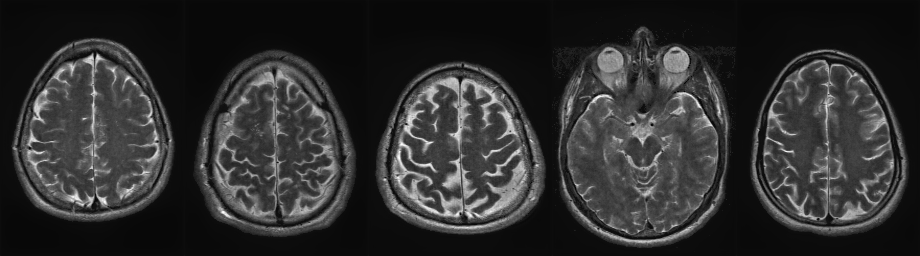

epochs: [1/150], batchs: [700/1101], time: 344s
Parameter containing:
tensor([0.0291], device='cuda:0', requires_grad=True)
Discriminator --- Loss_D_real: 0.000654, Loss_D_fake: 0.000616
Unet_dc --- Loss_G_dc: 0.000636, loss_L1_dc: 0.000944


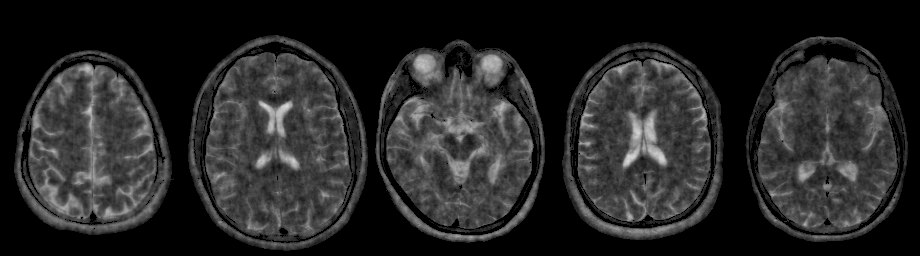

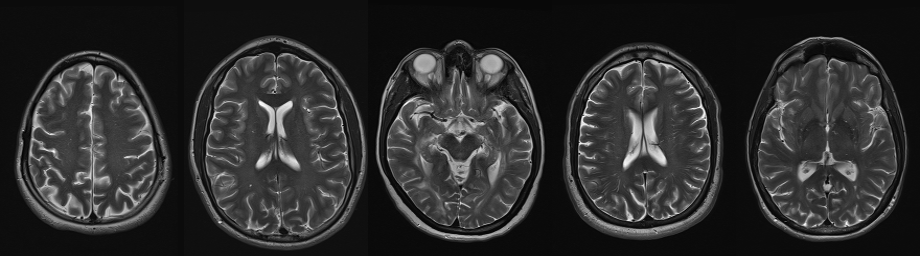

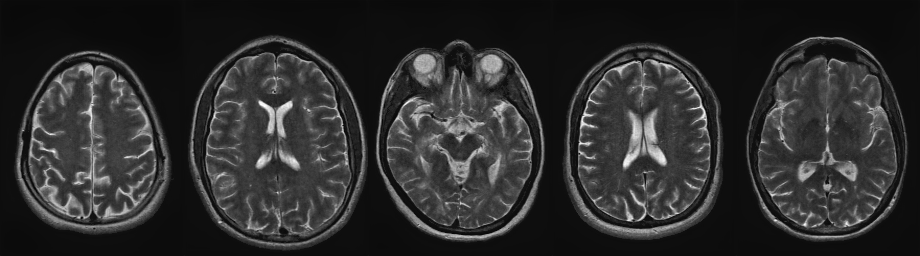

epochs: [1/150], batchs: [710/1101], time: 349s
Parameter containing:
tensor([0.0293], device='cuda:0', requires_grad=True)
Discriminator --- Loss_D_real: 0.000671, Loss_D_fake: 0.000600
Unet_dc --- Loss_G_dc: 0.000647, loss_L1_dc: 0.001163


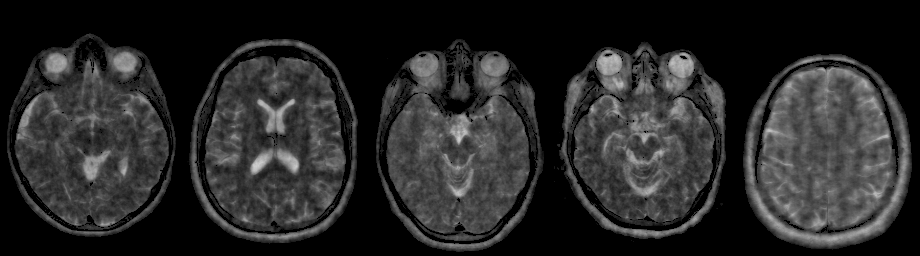

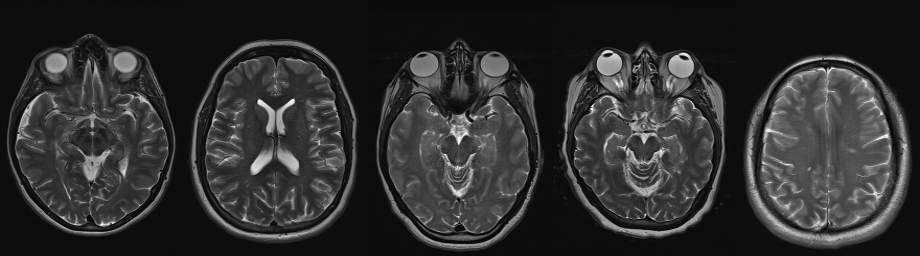

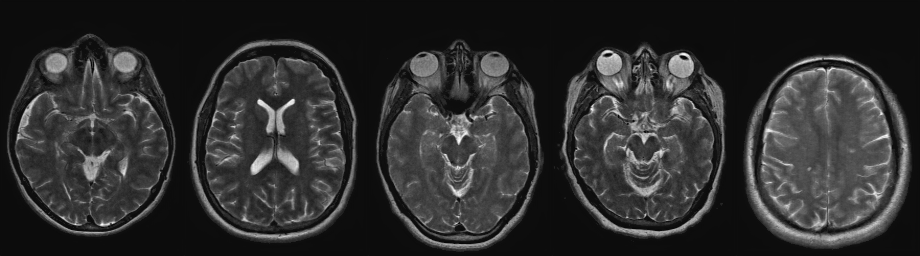

epochs: [1/150], batchs: [720/1101], time: 354s
Parameter containing:
tensor([0.0289], device='cuda:0', requires_grad=True)
Discriminator --- Loss_D_real: 0.000578, Loss_D_fake: 0.000515
Unet_dc --- Loss_G_dc: 0.000562, loss_L1_dc: 0.000975


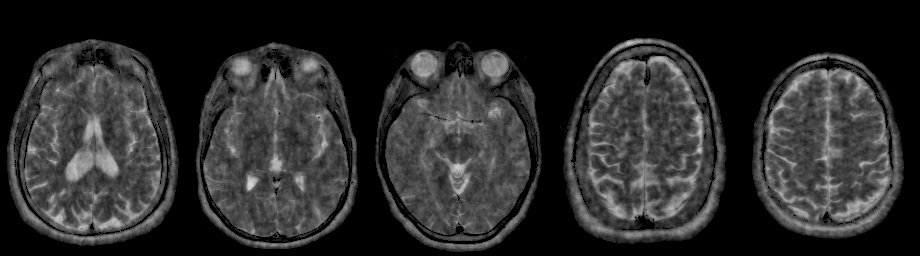

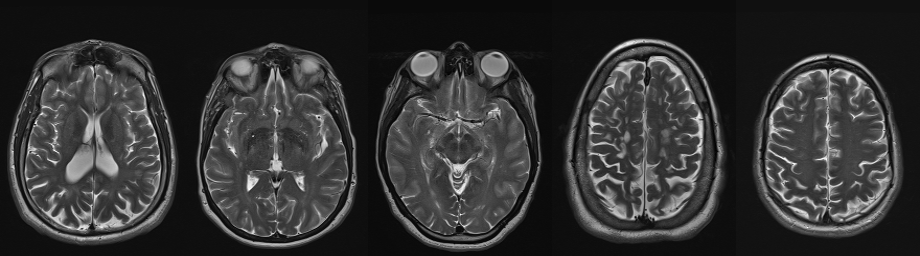

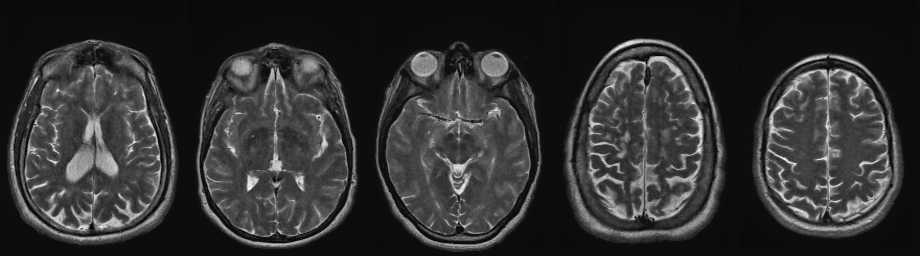

epochs: [1/150], batchs: [730/1101], time: 359s
Parameter containing:
tensor([0.0287], device='cuda:0', requires_grad=True)
Discriminator --- Loss_D_real: 0.000573, Loss_D_fake: 0.000532
Unet_dc --- Loss_G_dc: 0.000556, loss_L1_dc: 0.001065


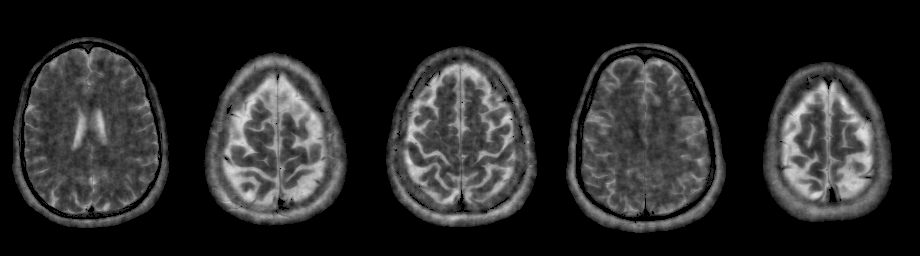

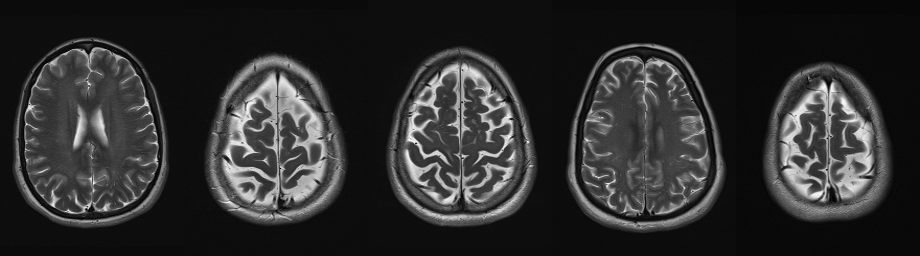

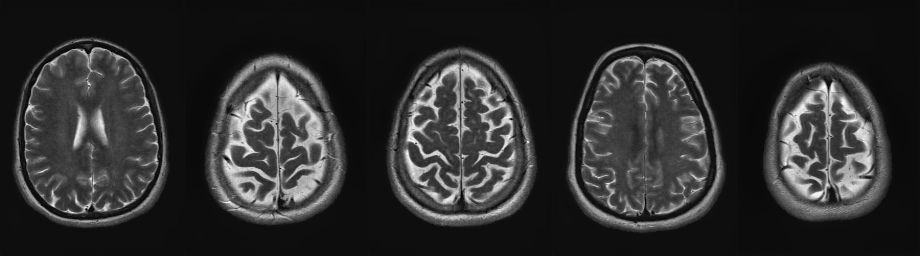

epochs: [1/150], batchs: [740/1101], time: 364s
Parameter containing:
tensor([0.0289], device='cuda:0', requires_grad=True)
Discriminator --- Loss_D_real: 0.000565, Loss_D_fake: 0.000543
Unet_dc --- Loss_G_dc: 0.000549, loss_L1_dc: 0.001027


In [ ]:
if __name__ == '__main__':

    os.environ["CUDA_VISIBLE_DEVICES"] = '1'
    lrG = lrD = lrG_dc = 2e-4
    niter = 150
    batch_size = 8
    display_iters = 10
    lambda_l1 = 1000
    lambda_dll2 = 0.1
    lambda_dc = 1000
    K = 1

    epoch = 0
    gen_iterations = 0
    errD_real_sum = errD_fake_sum = 0
    errL1_sum = errG_sum = errdc_sum = 0
    errL1_dc_sum = errG_dc_sum = 0

    t0 = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    dataLoader = real_data_loader(split='train')
    trainLoader = data.DataLoader(dataLoader, batch_size=batch_size, shuffle=True)

    netG = Unet(input_channels=2, output_channels=2, num_filters=[2**i for i in range(5, 10)])
    netD = Basic_D(input_channels=2, output_channels=2, num_filters=[32, 64, 128, 256])
    unet_dc = Unet_with_DC(
        input_channels=2, 
        output_channels=2, 
        num_filters=[2**i for i in range(5, 10)],
        lambda_dll2=lambda_dll2,
        K=K)

    netG.to(device)
    netD.to(device)
    unet_dc.to(device)

    optimizerD = optim.Adam(netD.parameters(), lr = lrD, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr = lrG, betas=(0.5, 0.999))
    optimizerG_dc = optim.Adam(unet_dc.parameters(), lr = lrG_dc, betas=(0.5, 0.999))
    print(unet_dc)
    
    while epoch < niter: 
        
        epoch += 1
        for idx, (inputs, targets, csms, masks) in enumerate(trainLoader):
            
            if gen_iterations%display_iters == 0:
                if gen_iterations%(5*display_iters) == 0:           
                    clear_output()
                
                sampling = True
                inputs_show, idxs = showImage(inputs, sampling=sampling)
                
                sampling = False
                targets_show, idxs = showImage(targets, idxs=idxs, sampling=sampling)

                inputs = inputs.to(device)
                targets = targets.to(device)
                csms = csms.to(device)
                masks = masks.to(device)
                
                # outputs = netG(inputs)
                outputs = unet_dc(inputs, csms, masks)
                outputs_np = np.squeeze(np.asarray(outputs.cpu().detach()))
                outputs_show, idxs = showImage(outputs_np, idxs=idxs, sampling=sampling)

                print('epochs: [%d/%d], batchs: [%d/%d], time: %ds'
                % (epoch, niter, idx, 8800//batch_size+1, time.time()-t0))

                print(unet_dc.lambda_dll2)

                print('Discriminator --- Loss_D_real: %f, Loss_D_fake: %f'
                % (errD_real_sum/display_iters, errD_fake_sum/display_iters))

#                 print('Unet --- Loss_G: %f, loss_L1: %f, loss_fidelity: %f'
#                 % (errG_sum/display_iters, errL1_sum/display_iters, errdc_sum/display_iters))

                print('Unet_dc --- Loss_G_dc: %f, loss_L1_dc: %f'
                % (errG_dc_sum/display_iters, errL1_dc_sum/display_iters))

                errD_real_sum = errD_fake_sum = 0
                errL1_sum = errG_sum = errdc_sum = 0
                errL1_dc_sum = errG_dc_sum = 0
                
                # A = Back_forward(csms, masks, lambda_dll2)
                # rhs = lambda_dll2*outputs + inputs
                # dc_layer = DC_layer(A, rhs)
                # tmp_images = dc_layer.CG_iter()
                # tmp_images_np = np.squeeze(np.asarray(tmp_images.cpu().detach()))
                # tmp_show, idxs = showImage(tmp_images_np, idxs=idxs, sampling=sampling)
                
            inputs = inputs.to(device)
            targets = targets.to(device)
            csms = csms.to(device)
            masks = masks.to(device)

            # train discriminator
            errD_real, errD_fake = netD_train(inputs, targets, netD, netG, optimizerD)
            errD_real_sum += errD_real
            errD_fake_sum += errD_fake

#             # train generator without dc layer, but with fidelity loss
#             AtA = Back_forward(csms, masks, lambda_dll2).AtA
#             errG, errL1, errdc = netG_train(inputs, targets, AtA, \
#                 netD, netG, optimizerG, lambda_l1, lambda_dc)
#             errG_sum += errG
#             errL1_sum += errL1
#             errdc_sum += errdc

            # train generator with dc layer, but without fidelity loss
            errG_dc, errL1_dc = netG_dc_train(inputs, targets, csms, masks, \
                netD, unet_dc, optimizerG_dc, lambda_l1)
            errG_dc_sum += errG_dc
            errL1_dc_sum = errL1_dc 

            gen_iterations += 1
